# License Plate Recognition

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

/home/claus/anaconda3/envs/course/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Generate training data

In [67]:
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw
from PIL import ImageOps

In [68]:
PATH = 'data/lpr/'
#!wget -O data/lpr/sample.jpg http://www.esbjergkommune.dk/Files/Billeder/Borger/Vej%20og%20trafik/Offentlig%20vej/Villavej_418x235.jpg
sample = f'{PATH}sample.jpg'
image = Image.open(sample)

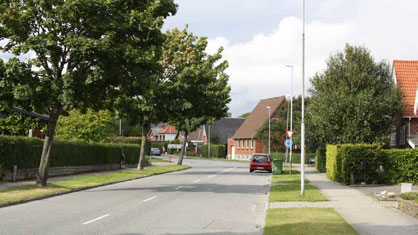

In [69]:
image

In [70]:
image.size

(418, 235)

### Generate license plate

In [254]:
def license_plate(image, license):
    font = ImageFont.truetype('/usr/share/fonts/truetype/ubuntu-font-family/Ubuntu-C.ttf', 80)
    w = 300
    h = 100
    red_width = 2
    red_margin = 5
    size = (w, h)
    plate = Image.new('RGB', size, "white")
    
    draw = ImageDraw.Draw(plate)
    draw.line((red_margin,red_margin) + (red_margin,h-red_margin), width=red_width, fill="red")
    draw.line((red_margin,h - red_width - red_margin) + (w-red_margin,h-red_width-red_margin), width=red_width, fill="red")
    draw.line((w-red_margin,h-red_width-red_margin) + (w-red_margin, red_margin), width=red_width, fill="red")
    draw.line((w-red_margin,red_margin) + (red_margin, red_margin), width=red_width, fill="red")
    font_size = font.getsize(license)
    
    draw.text(((w-font_size[0])/2,(h-2*red_margin-font_size[1])/2), license, font=font, fill="black")
    # ImageOps.colorize(plate, (0,0,0), (0,255,0))
    image.paste(plate, box=(10,10))


    return image

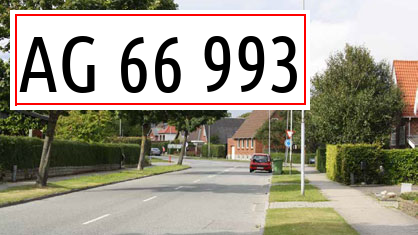

In [255]:
license_plate(image, 'AG 66 993')